## Simple example reconstructing the sin function


## Imports and dataset

2023-02-16 11:12:02.298322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 11:12:03.420004: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maxi/Repos/SGpp/lib:
2023-02-16 11:12:03.420111: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maxi/Repos/SGpp/lib:
2023-02-16 11:12:03.420118: W tensorflow/compiler/tf2tensorrt/utils/py_utils

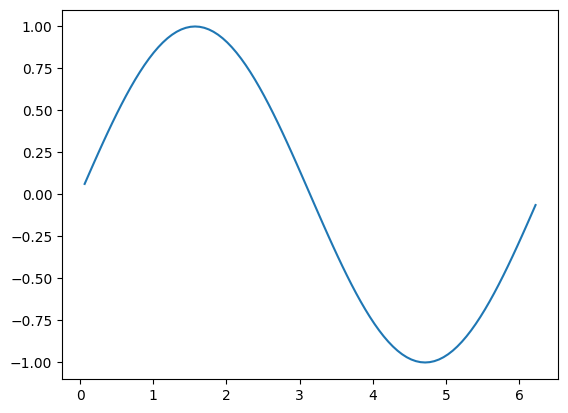

In [1]:
import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

import sklearn.metrics

def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

X = []
Y = []

num_samples = 100

for i in range(1, num_samples):
    X.append(2.0*math.pi/num_samples * float(i))
    Y.append(math.sin(2.0*math.pi/num_samples * float(i)))

plt.plot(X, Y)
plt.show()

X = torch.Tensor(X)
Y = torch.Tensor(Y)

X = X.reshape(-1, 1)

dataset = HPO.Dataset(X, Y)


## Hyperparameterspace & Model & Function

In [2]:
BUDGET = 100
VERBOSE = 2


hyperparameterspace = {
    'loss': ["list", 'binary_crossentropy', 'categorical_crossentropy', 'binary_crossentropy', 'mean_squared_error', 'mean_absolute_error'],
    #'loss': ["list", 'mean_absolute_error', 'log_cosh'],
    'epochs': ["interval-int", 1, 400]
}

##################### Model for grid and random search #####################

# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_shape=(1,), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation=None))
    # Compile model
    model.compile(loss='mean_squared_error',
                  optimizer='adam', metrics=['mean_squared_error'])
    return model

##################### Blackbox function for bayesian optimization #####################


hyperparameterspace_special = {
    'loss': ['binary_crossentropy', 'categorical_crossentropy', 'binary_crossentropy', 'mean_squared_error', 'mean_absolute_error'],
    'epochs': [1, 400]
}

def blackboxfunction(params):
    index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
    loss = hyperparameterspace_special["loss"][index]
    
    epochs = int(params[1])


    # Function to create model, required for KerasClassifier
    def create_model():
        # create model
        model = Sequential()
        model.add(Dense(10, input_shape=(1,), activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(1, activation=None))
        # Compile model
        model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
        return model

    model = KerasRegressor(model=create_model, verbose=0)

    model.fit(X, Y, epochs=epochs)

    Y_predicted = model.predict(X)

    return -sklearn.metrics.mean_squared_error(Y, Y_predicted)
    

##################### Function for sparse grid search #####################

class ExampleFunction(pysgpp.ScalarFunction):

    def __init__(self):
        super(ExampleFunction, self).__init__(2)


    def eval(self, x):
        index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = hyperparameterspace_special["loss"][index]
        epochs = int(from_standard(1, 400, x[1]))
        
        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(10, input_shape=(1,), activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(1, activation=None))
            # Compile model
            model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        model.fit(X, Y, epochs=epochs)
        Y_predicted = model.predict(X)

        return sklearn.metrics.mean_squared_error(Y.tolist(), Y_predicted.tolist())

## Grid search

Fitting 5 folds for each of 50 candidates, totalling 250 fits


2023-02-16 11:12:05.973959: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-16 11:12:05.974017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maxi-XPS-15-9560): /proc/driver/nvidia/version does not exist
2023-02-16 11:12:05.975186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV] END ................epochs=20, loss=binary_crossentropy; total time=   1.6s
[CV] END ................epochs=20, loss=binary_crossentropy; total time=   0.1s
[CV] END ................epochs=20, loss=binary_crossentropy; total time=   0.1s
[CV] END ................epochs=20, loss=binary_crossentropy; total time=   0.1s
[CV] END ................epochs=20, loss=binary_crossentropy; total time=   0.1s
[CV] END ...........epochs=20, loss=categorical_crossentropy; total time=   0.1s
[CV] END ...........epochs=20, loss=categorical_crossentropy; total time=   0.1s
[CV] END ...........epochs=20, loss=categorical_crossentropy; total time=   0.1s
[CV] END ...........epochs=20, loss=categorical_crossentropy; total time=   0.1s
[CV] END ...........epochs=20, loss=categorical_crossentropy; total time=   0.1s
[CV] END ................epochs=20, loss=binary_crossentropy; total time=   0.1s
[CV] END ................epochs=20, loss=binary_crossentropy; total time=   0.1s
[CV] END ................epo

/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/maxi/.local/lib/python3.10/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/maxi/.local/lib/python3.10/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/home/maxi/.local/lib/python3.10/site-packages

Best result:
-0.5596736265260315
Corresponding parameters:
{'epochs': 340, 'loss': 'mean_squared_error'}


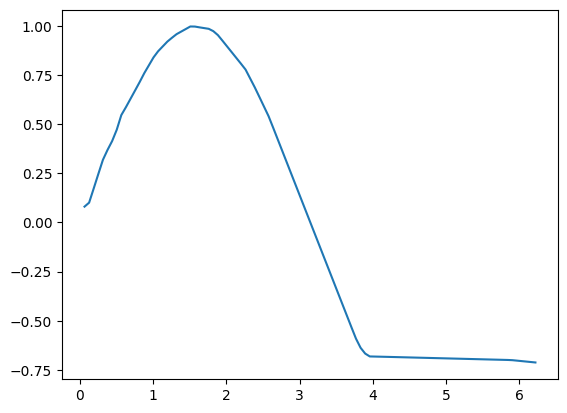

In [3]:
model = KerasRegressor(model=create_model, verbose=0)
optimization = HPO.Optimization(
    dataset, model, hyperparameterspace, type="grid_search", budget=BUDGET, verbosity=VERBOSE)
result = optimization.fit()
print("Best result:")
print(result.best_score_)
print("Corresponding parameters:")
print(result.best_params_)

Y_predicted = result.predict(torch.Tensor(X))

plt.plot(X, Y_predicted)
plt.show()


## Random search

/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ................epochs=20, loss=binary_crossentropy; total time=   0.1s
[CV] END ................epochs=20, loss=binary_crossentropy; total time=   0.1s
[CV] END ................epochs=20, loss=binary_crossentropy; total time=   0.1s
[CV] END ................epochs=20, loss=binary_crossentropy; total time=   0.0s
[CV] END ................epochs=20, loss=binary_crossentropy; total time=   0.0s
[CV] END ...........epochs=20, loss=categorical_crossentropy; total time=   0.1s
[CV] END ...........epochs=20, loss=categorical_crossentropy; total time=   0.1s
[CV] END ...........epochs=20, loss=categorical_crossentropy; total time=   0.0s
[CV] END ...........epochs=20, loss=categorical_crossentropy; total time=   0.1s
[CV] END ...........epochs=20, loss=categorical_crossentropy; total time=   0.1s
[CV] END ................epochs=20, loss=binary_crossentropy; total time=   0.1s
[CV] END ................epochs=20, loss=binary

/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/maxi/.local/lib/python3.10/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/maxi/.local/lib/python3.10/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/home/maxi/.local/lib/python3.10/site-packages

Best result:
-1.603049559797471
Corresponding parameters:
{'loss': 'mean_squared_error', 'epochs': 340}


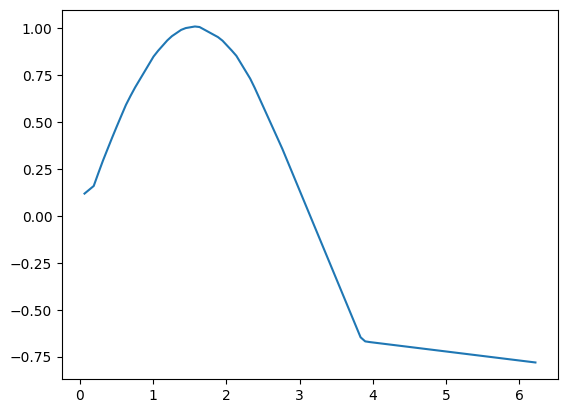

In [4]:
model = KerasRegressor(model=create_model, verbose=0)
optimization = HPO.Optimization(dataset, model, hyperparameterspace, type="random_search", budget=BUDGET, verbosity=VERBOSE)
result = optimization.fit()
print("Best result:")
print(result.best_score_)
print("Corresponding parameters:")
print(result.best_params_)

Y_predicted = result.predict(torch.Tensor(X).reshape(-1, 1))

plt.plot(X,Y_predicted)
plt.show()

## Bayesian Optimization 

https://thuijskens.github.io/2016/12/29/bayesian-optimisation/ 

Progress: [####################] 100.0%
Current time per iteration: 5.346715305000544
Approx. time remaining: 0.0
Best MSE:
-0.00045082945
With Hyperparameters: 
loss: mean_squared_error
epochs: 296.42261972862025
[array([  0.92246186, 296.42261973])]


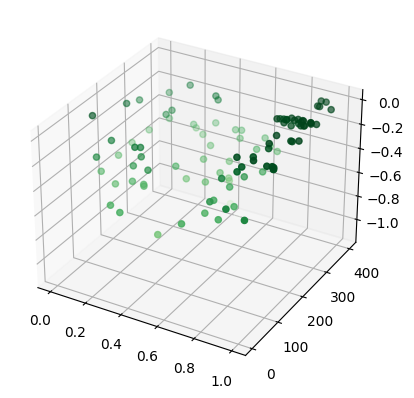

In [5]:
optimization = HPO.Optimization(dataset, blackboxfunction, hyperparameterspace, type="bayesian", budget=BUDGET, verbosity=VERBOSE)
result = optimization.fit()

fig = plt.figure()
ax = plt.axes(projection='3d')

x = [result[0][i][0] for i in range(len(result[0]))]
y = [result[0][i][1] for i in range(len(result[0]))]

ax.scatter3D(x, y, result[1], c=result[1], cmap='Greens')

index_best = 0
for i in range(len(result[1])):
    if result[1][i] == max(result[1]):
        index_best = i

best_score = result[1][index_best]
best_params = result[0][index_best]


print("Best MSE:")
print(best_score)
print("With Hyperparameters: ")
i = 0
for key in hyperparameterspace.keys():
    if hyperparameterspace[key][0] == "list":
        index = int(best_params[i]*(len(hyperparameterspace_special[key])-1))
        print(key + ": " + str(hyperparameterspace_special[key][index]))
    else:
        print(key + ": " + str(best_params[i]))
    i += 1


print([result[0][i] for i in range(len(result[0])) if result[1][i] == max(result[1])])
#print(result)

## Sparse grid search

In [6]:
f = ExampleFunction()

optimization = HPO.Optimization(dataset, f, hyperparameterspace, type="sparse", budget=BUDGET, verbosity=VERBOSE)
result = optimization.fit()


Adaptive grid generation (Ritter-Novak)...


: 

: 